In [1]:
!pip install osmnx networkx

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100.5/100.5 kB 2.0 MB/s eta 0:00:00


In [12]:
!pip install geopandas

In [22]:
import osmnx as ox
import geopandas as gpd
import networkx as nx
import pandas as pd
import json

In [43]:
# --- 2. Download e Preparazione della Rete Stradale Reale---

print("Download della rete stradale dall'area Flegrea...")
centro_flegreo = ox.geocode("Pozzuoli, Italia")
G_real_mdg = ox.graph_from_point(centro_flegreo, dist=30000, network_type='drive')
print("Download completato.")

print("Aggiunta degli attributi 'tau' e 'capacity' al grafo...")
velocita_stimata_kmh = {'motorway': 80, 'trunk': 80, 'primary': 70, 'secondary': 50, 'tertiary': 40, 'residential': 30, 'unclassified': 30}
flusso_per_corsia_veicoli_ora = 1800
for u, v, data in G_real_mdg.edges(data=True):
    lunghezza_km = data['length'] / 1000
    tipo_strada = data.get('highway', 'unclassified')
    if isinstance(tipo_strada, list): tipo_strada = tipo_strada[0]
    velocita = velocita_stimata_kmh.get(tipo_strada, 30)
    data['tau'] = lunghezza_km / velocita
    try:
        num_corsie_str = data.get('lanes', ['1'])[0]
        num_corsie = int(num_corsie_str)
    except (ValueError, TypeError): num_corsie = 1
    data['capacity'] = num_corsie * flusso_per_corsia_veicoli_ora

Download della rete stradale dall'area Flegrea...
Download completato.
Aggiunta degli attributi 'tau' e 'capacity' al grafo...


In [44]:
print("\nInizio Mappatura Sorgenti e Pozzi...")
file_geojson_dati = "/content/campi_flegrei_features.json"
gdf = gpd.read_file(file_geojson_dati)

sinks_real_nodes = []
sources_to_map = {}

popolazione_comuni = {
    "Quarto": 41000, "Napoli - Chiaiano": 23000, "Napoli - Arenella": 70000,
    "Giugliano in Campania": 124000, "Napoli - Vomero": 46000, "Marano di Napoli": 60000,
    "Napoli - Fuorigrotta": 72000, "Bacoli": 26000, "Monte di Procida": 12000,
    "Napoli - Bagnoli": 23000, "Pozzuoli": 80000, "Napoli - Soccavo": 45000,
    "Napoli - Pianura": 58000, "Napoli - S. Ferdinando": 18000, "Napoli - Montecalvario": 20000,
    "Napoli - Chiaia": 40000, "Napoli - Posillipo": 23000
}

for _, row in gdf.iterrows():
    dest_name = row.get('Area_di_incontro')
    if dest_name and pd.notna(dest_name):
        # NOTA: non usiamo più il centroide perché il file contiene già Point
        lon, lat = row['geometry'].x, row['geometry'].y
        # Eseguiamo la ricerca sul grafo non proiettato
        nodo_pozzo = ox.nearest_nodes(G_real_mdg, X=lon, Y=lat)
        if nodo_pozzo not in sinks_real_nodes: sinks_real_nodes.append(nodo_pozzo)

    source_str = row.get('Località')
    if source_str and pd.notna(source_str):
        source_list = [c.strip() for c in source_str.split(',') if c.strip()]
        for comune in source_list:
            if comune in popolazione_comuni and comune not in sources_to_map:
                sources_to_map[comune] = popolazione_comuni[comune]


Inizio Mappatura Sorgenti e Pozzi...


In [45]:
sources_real = {}
print("\nMappatura finale delle Sorgenti...")
for comune, pop in sources_to_map.items():
    try:
        coords = ox.geocode(f"{comune}, Italia")
        # Eseguiamo la ricerca sul grafo non proiettato
        nodo_sorgente = ox.nearest_nodes(G_real_mdg, X=coords[1], Y=coords[0])
        sources_real[nodo_sorgente] = sources_real.get(nodo_sorgente, 0) + pop
        print(f"  -> Sorgente '{comune}' (Pop: {pop}) assegnata al nodo: {nodo_sorgente}")
    except Exception as e:
        print(f"ATTENZIONE: Impossibile geocodificare '{comune}'. Errore: {e}")


Mappatura finale delle Sorgenti...
  -> Sorgente 'Napoli - Chiaiano' (Pop: 23000) assegnata al nodo: 5303636960
  -> Sorgente 'Napoli - Arenella' (Pop: 70000) assegnata al nodo: 417909585
  -> Sorgente 'Giugliano in Campania' (Pop: 124000) assegnata al nodo: 2423424490
  -> Sorgente 'Quarto' (Pop: 41000) assegnata al nodo: 5540038702
  -> Sorgente 'Napoli - S. Ferdinando' (Pop: 18000) assegnata al nodo: 10810850413
  -> Sorgente 'Napoli - Montecalvario' (Pop: 20000) assegnata al nodo: 232357034
  -> Sorgente 'Napoli - Chiaia' (Pop: 40000) assegnata al nodo: 3465094537
  -> Sorgente 'Napoli - Posillipo' (Pop: 23000) assegnata al nodo: 4209080614
  -> Sorgente 'Napoli - Bagnoli' (Pop: 23000) assegnata al nodo: 1379210332
  -> Sorgente 'Pozzuoli' (Pop: 80000) assegnata al nodo: 4338857457
  -> Sorgente 'Napoli - Soccavo' (Pop: 45000) assegnata al nodo: 4954374774
  -> Sorgente 'Napoli - Pianura' (Pop: 58000) assegnata al nodo: 926204362
  -> Sorgente 'Bacoli' (Pop: 26000) assegnata al no

In [46]:
# --- 4. Semplificazione a DiGraph ---
# Lo facciamo solo ora, dopo tutte le operazioni geografiche
print("\nSemplificazione finale del grafo...")
G_simple = nx.DiGraph()
G_simple.add_nodes_from(G_real_mdg.nodes(data=True)) # Copia i nodi con tutti i loro dati
for u, v, data in G_real_mdg.edges(data=True):
    if G_simple.has_edge(u, v): G_simple.edges[u, v]['capacity'] += data['capacity']
    else: G_simple.add_edge(u, v, **data)
# Non copiamo più gli attributi globali del grafo per evitare problemi di salvataggio

# --- 5. Sanificazione e Salvataggio ---
print("Sanificazione e salvataggio del grafo...")
for _, data in G_simple.nodes(data=True):
    for key in list(data.keys()):
        if not isinstance(data[key], (str, int, float, bool)): del data[key]
for _, _, data in G_simple.edges(data=True):
    for key in list(data.keys()):
        if not isinstance(data[key], (str, int, float, bool)): del data[key]

nx.write_graphml(G_simple, "grafo_flegreo.graphml")
dati_per_analisi = {'sources': sources_real, 'sinks': sinks_real_nodes}
with open("sorgenti_pozzi.json", 'w') as f: json.dump(dati_per_analisi, f)

print("\nProcesso completato.")


Semplificazione finale del grafo...
Sanificazione e salvataggio del grafo...

Processo completato.



--- Visualizzazione del Grafo con Sorgenti e Pozzi ---
Mostrando il grafico... Chiudi la finestra per continuare.


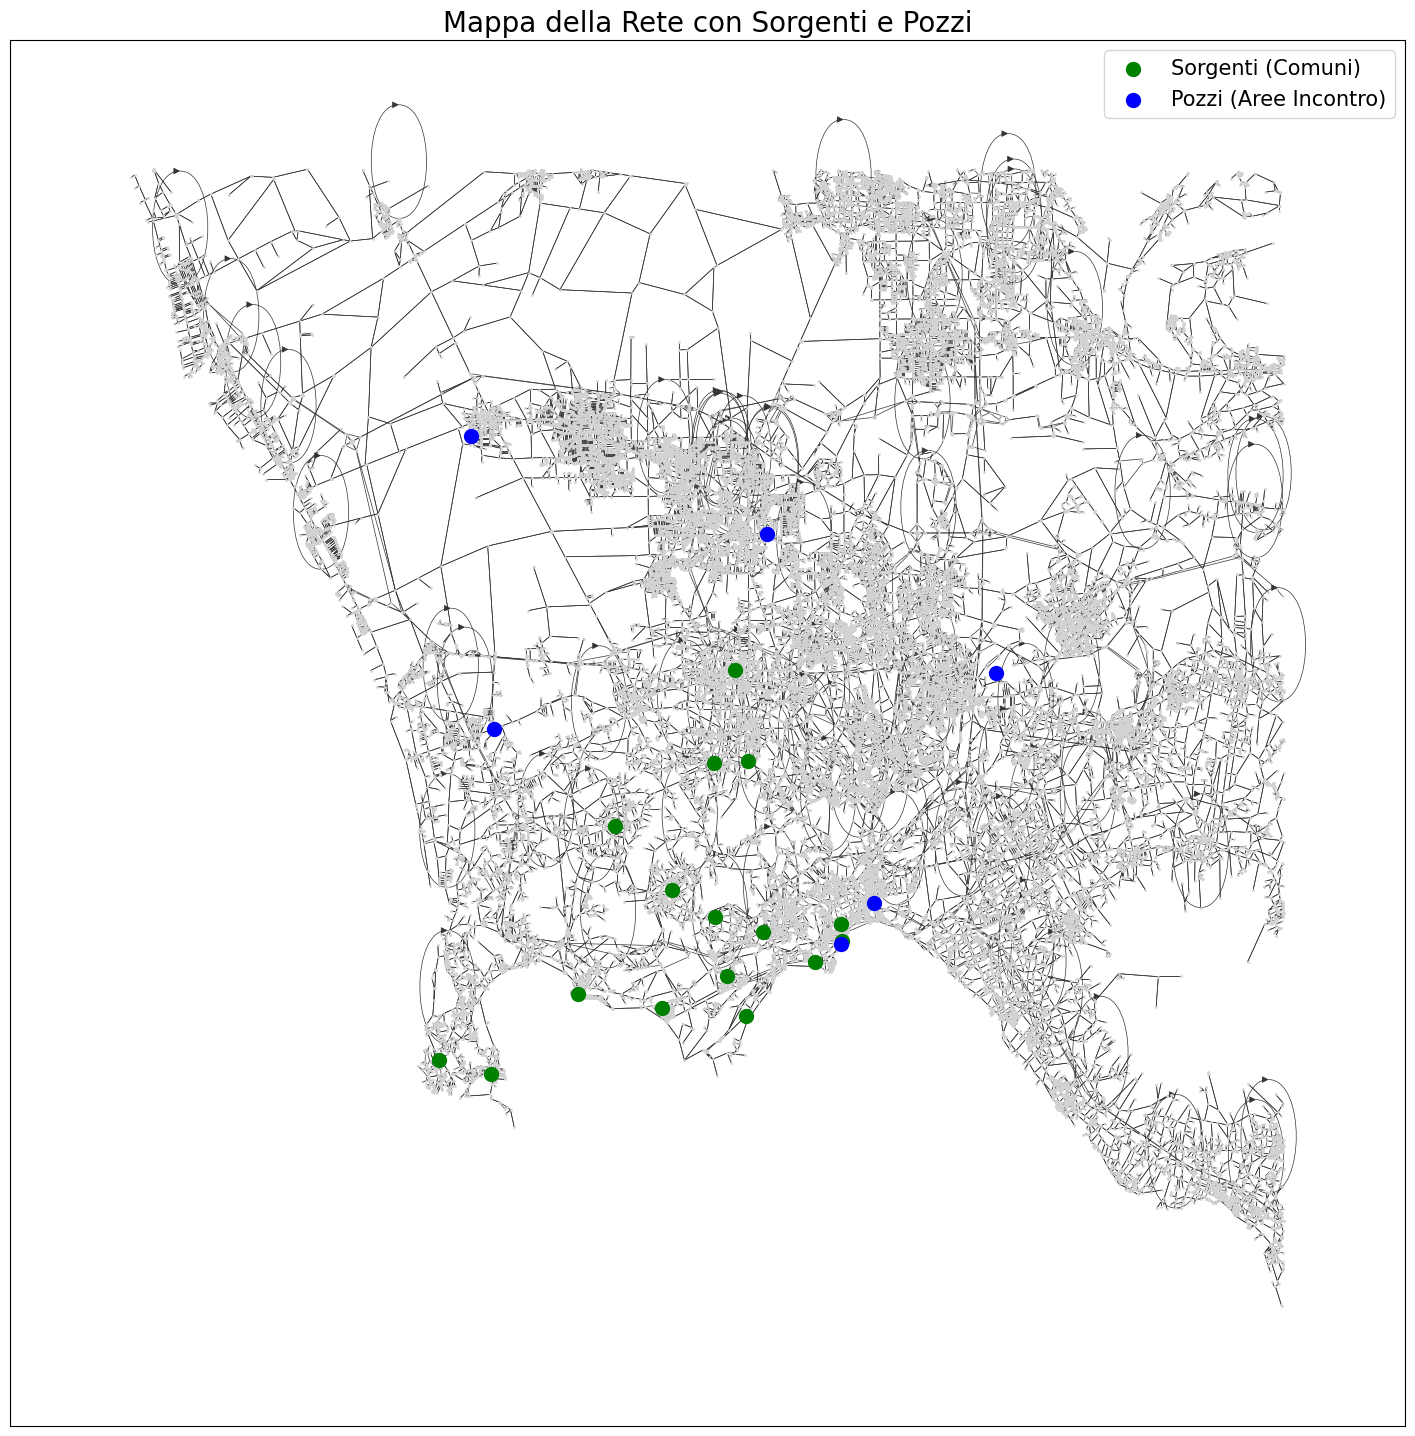

In [47]:
import matplotlib.pyplot as plt
print("\n--- Visualizzazione del Grafo con Sorgenti e Pozzi ---")

try:
    # Estrai le coordinate x, y di ogni nodo per il plottaggio
    posizioni = {node: (data['x'], data['y']) for node, data in G_simple.nodes(data=True) if 'x' in data and 'y' in data}

    fig, ax = plt.subplots(figsize=(18, 18))

    # 1. Disegna la rete stradale di base come sfondo (grigio chiaro)
    nx.draw_networkx_nodes(G_simple, posizioni, ax=ax, node_size=1, node_color='lightgray')
    nx.draw_networkx_edges(G_simple, posizioni, ax=ax, edge_color='#333333', width=0.5, arrows=False)

    # 2. Disegna i nodi SORGENTE in verde e più grandi
    #    list(sources_real.keys()) prende gli ID dei nodi dal tuo dizionario delle sorgenti
    nx.draw_networkx_nodes(G_simple, posizioni, ax=ax,
                           nodelist=list(sources_real.keys()),
                           node_color='green',
                           node_size=100,
                           label='Sorgenti (Comuni)')

    # 3. Disegna i nodi POZZO in blu e più grandi
    #    sinks_real_nodes è la tua lista di ID dei nodi di destinazione
    nx.draw_networkx_nodes(G_simple, posizioni, ax=ax,
                           nodelist=sinks_real_nodes,
                           node_color='blue',
                           node_size=100,
                           label='Pozzi (Aree Incontro)')

    ax.set_title("Mappa della Rete con Sorgenti e Pozzi", fontsize=20)
    ax.set_facecolor('white')
    ax.legend(prop={'size': 15}) # Aggiunge la legenda per capire i colori

    print("Mostrando il grafico... Chiudi la finestra per continuare.")
    plt.show()

except Exception as e:
    print(f"\nATTENZIONE: Impossibile creare la visualizzazione completa. Errore: {e}")



Creazione del grafico di debug...


<ipython-input-33-3309365354>:30: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(by

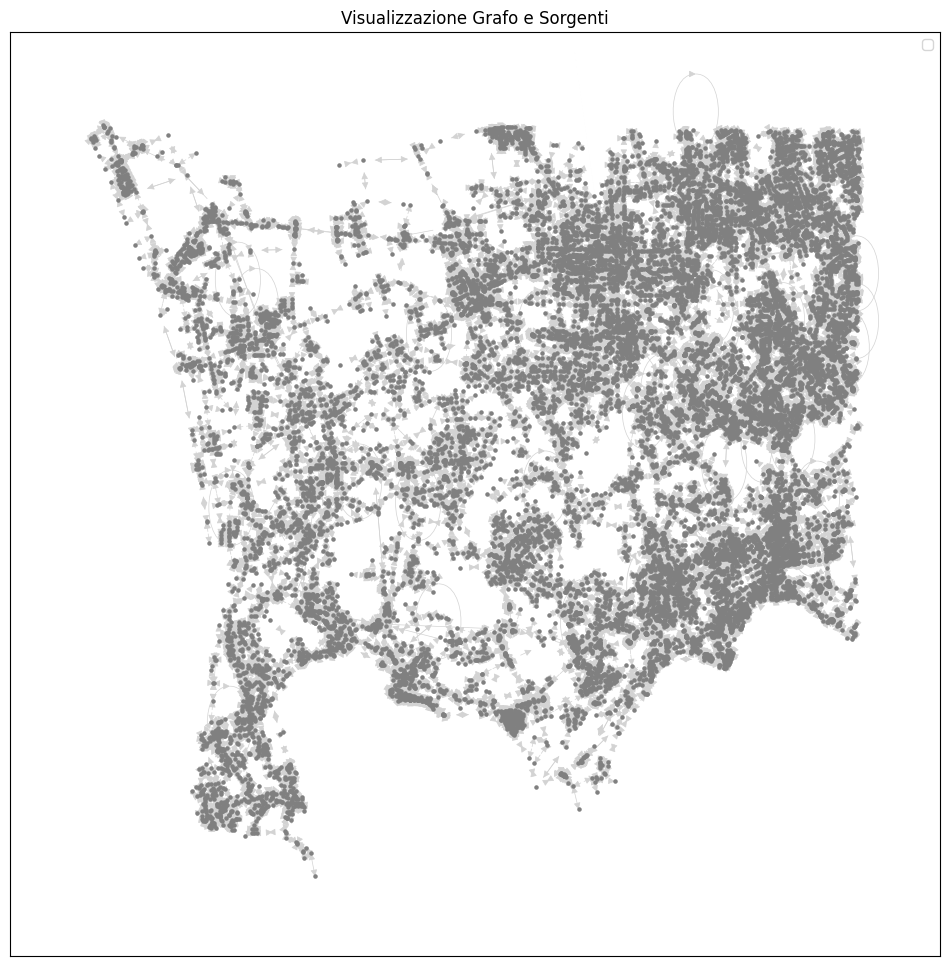

In [33]:

import matplotlib.pyplot as plt

print("\nCreazione del grafico di debug...")

# Estrai le coordinate dei nodi del grafo
node_coords = {node: (data['x'], data['y']) for node, data in G_simple.nodes(data=True)}

# Estrai le coordinate delle sorgenti che abbiamo geocodificato
source_coords_list = []
for comune, pop in sources_to_map.items():
    if pop > 0:
        try:
            coords = ox.geocode(f"{comune}, Italia")
            # Dobbiamo proiettare anche queste coordinate per metterle sullo stesso grafico
            gdf_point = gpd.GeoDataFrame(geometry=[Point(coords[1], coords[0])], crs="EPSG:4326").to_crs(G_simple.graph['crs'])
            source_coords_list.append((gdf_point.geometry.x.iloc[0], gdf_point.geometry.y.iloc[0]))
        except:
            continue

# Plotta il grafo
fig, ax = plt.subplots(figsize=(12, 12))
nx.draw_networkx_nodes(G_simple, node_coords, ax=ax, node_size=5, node_color='gray')
nx.draw_networkx_edges(G_simple, node_coords, ax=ax, edge_color='lightgray', width=0.5)

# Sovrapponi le coordinate delle sorgenti con dei pallini rossi
if source_coords_list:
    xs, ys = zip(*source_coords_list)
    ax.scatter(xs, ys, color='red', s=50, zorder=5, label='Sorgenti Geocodificate')

ax.legend()
plt.title("Visualizzazione Grafo e Sorgenti")
plt.show()

In [35]:

import pandas as pd
from shapely.geometry import Point # Assicurati di importare Point

print("\n--- INIZIO SESSIONE DI DEBUG DELLA MAPPATURA ---")

debug_results = []

# Usiamo la lista di comuni unici che abbiamo già creato
for comune in sources_to_map.keys():
    try:
        # PASSO 1: Geocodifica del comune per ottenere le coordinate
        coords = ox.geocode(f"{comune}, Italia")
        lat, lon = coords[0], coords[1]

        # PASSO 2: Ricerca del nodo più vicino sul grafo
        # Usiamo G_real_mdg, che è il grafo originale e geometricamente affidabile
        nearest_node = ox.nearest_nodes(G_real_mdg, X=lon, Y=lat)

        debug_results.append({
            "Comune": comune,
            "Lat Trovata": lat,
            "Lon Trovata": lon,
            "Nodo Mappato": nearest_node
        })
    except Exception as e:
        debug_results.append({
            "Comune": comune,
            "Lat Trovata": "ERRORE",
            "Lon Trovata": "ERRORE",
            "Nodo Mappato": str(e)
        })

# Visualizziamo i risultati in una tabella chiara con Pandas
df_debug = pd.DataFrame(debug_results)
print("Risultati del debug:")
print(df_debug)

# VERIFICA CRUCIALE: Controlliamo se tutti i nodi trovati sono uguali
if not df_debug.empty and 'Nodo Mappato' in df_debug.columns:
    unique_nodes = df_debug['Nodo Mappato'].nunique()
    print(f"\nNumero di nodi unici trovati: {unique_nodes}")
    if unique_nodes == 1:
        print("!!! PROBLEMA CONFERMATO: Tutti i comuni mappano sullo stesso nodo. Controllare il grafo o la chiamata a nearest_nodes.")
    else:
        print("--> OK: I comuni sono stati mappati su nodi diversi.")


--- INIZIO SESSIONE DI DEBUG DELLA MAPPATURA ---
Risultati del debug:
                    Comune  Lat Trovata  Lon Trovata  Nodo Mappato
0        Napoli - Chiaiano    40.898703    14.208252    1347843902
1        Napoli - Arenella    40.842938    14.214655    1347843902
2    Giugliano in Campania    40.928322    14.201123    1347843902
3                   Quarto    40.877194    14.140159    1347843902
4   Napoli - S. Ferdinando    40.838190    14.260219    1347843902
5   Napoli - Montecalvario    40.845531    14.255111    1347843902
6          Napoli - Chiaia    40.834966    14.242176    1347843902
7       Napoli - Posillipo    40.814926    14.205867    1347843902
8         Napoli - Bagnoli    40.818009    14.163913    1347843902
9                 Pozzuoli    40.822643    14.121911    1347843902
10        Napoli - Soccavo    40.848094    14.190823    1347843902
11        Napoli - Pianura    40.856807    14.169665    1347843902
12                  Bacoli    40.796613    14.077783    13

In [53]:
# --- 4. Salvataggio su File (con sanificazione finale) ---

print("\nSanificazione finale del grafo per il salvataggio...")

# Tipi di dati di base che GraphML può gestire
allowed_types = (str, int, float, bool)

# Itera su tutti gli attributi di tutti i nodi e archi
# e rimuovi quelli che non sono tipi di base.
# Usiamo list(data.keys()) perché modifichiamo il dizionario mentre lo cicliamo.
for _, data in G_simple.nodes(data=True):
    for key in list(data.keys()):
        if not isinstance(data[key], allowed_types):
            del data[key]

for _, _, data in G_simple.edges(data=True):
    for key in list(data.keys()):
        if key == 'geometry':
            data[key] = data[key].wkt
        if not isinstance(data[key], allowed_types):
            del data[key]

# Rimuovi anche l'attributo 'crs' dal dizionario del grafo
if 'crs' in G_simple.graph:
    del G_simple.graph['crs']

# Ora il grafo contiene solo dati semplici e può essere salvato
print("Salvataggio del grafo sanificato...")
nx.write_graphml(G_simple, "grafo_flegreo_new.graphml")

# Il salvataggio di sorgenti e pozzi non cambia
dati_per_analisi = {'sources': sources_real, 'sinks': sinks_real_nodes}
with open("sorgenti_pozzi.json", 'w') as f:
    json.dump(dati_per_analisi, f)

print("\nProcesso completato. File creati con successo.")


Sanificazione finale del grafo per il salvataggio...
Salvataggio del grafo sanificato...

Processo completato. File creati con successo.


In [54]:
import folium
import pickle
import matplotlib.cm as cm
import matplotlib.colors as mcolors
import numpy as np
from shapely import wkt

In [55]:
nome_file_risultati = "/content/risultati_evacuazione.pkl"

try:
    with open(nome_file_risultati, 'rb') as f:
        risultati = pickle.load(f)

    # Estrai i dati dal dizionario caricato e assegnali alle variabili
    G_simple = risultati['grafo']
    sources_real = risultati['sorgenti']
    sinks_real_nodes = risultati['pozzi']
    best_time_real = risultati['tempo_ottimo']
    evacuation_plan_real = risultati['piano_flusso']

    print("Risultati caricati con successo.")
    print(f"Tempo di evacuazione calcolato: {best_time_real:.2f} ore")

except FileNotFoundError:
    print(f"ERRORE: File dei risultati '{nome_file_risultati}' non trovato.")
    print("Assicurati di aver prima eseguito il notebook di ottimizzazione.")

Risultati caricati con successo.
Tempo di evacuazione calcolato: 72.32 ore


In [56]:
import folium
from folium.plugins import BeautifyIcon

def visualizza_mappa_interattiva_finale(grafo, piano_flusso, best_time, sources, sinks):
    """
    Crea una mappa HTML interattiva leggendo la geometria delle strade dal file.
    """
    print("\n--- Creazione della Mappa Interattiva Finale ---")

    lats = [data['y'] for _, data in grafo.nodes(data=True)]
    lons = [data['x'] for _, data in grafo.nodes(data=True)]
    centro_mappa_lat = np.mean(lats)
    centro_mappa_lon = np.mean(lons)

    m = folium.Map(location=[centro_mappa_lat, centro_mappa_lon], zoom_start=12, tiles="CartoDB dark_matter")
    colormap = cm.get_cmap('hot_r', 100)

    for u, v, data in grafo.edges(data=True):
        flow = piano_flusso.get((u, v), 0)
        if flow > 1:
            total_capacity = data.get('capacity', 0) * best_time
            saturation = (flow / total_capacity * 100) if total_capacity > 0 else 0

            # Disegna solo le strade con un minimo di saturazione
            if saturation > 1 and 'geometry' in data:
                try:
                    # !!! MODIFICA CHIAVE: Riconverti la stringa WKT in un oggetto geometrico !!!
                    line_geometry = wkt.loads(data['geometry'])

                    # Ora puoi accedere a .coords come prima
                    # NOTA: Assumiamo che il grafo sia in lat/lon (EPSG:4326)
                    coords = [(point[1], point[0]) for point in line_geometry.coords]

                    colore_strada = mcolors.to_hex(colormap(int(saturation)))

                    linea = folium.PolyLine(
                        locations=coords, color=colore_strada,
                        weight=2 + (saturation / 100 * 8), opacity=0.8
                    )
                    popup_html = f"<b>Strada ({u} -> {v})</b><br>Flusso: {flow:,.0f}<br>Saturazione: {saturation:.1f}%"
                    linea.add_child(folium.Popup(popup_html))
                    linea.add_to(m)
                except Exception as e:
                    # Se c'è un problema con una singola geometria, lo segnaliamo ma continuiamo
                    # print(f"Impossibile disegnare l'arco ({u},{v}): {e}")
                    pass

    # Il resto della funzione per disegnare sorgenti e pozzi è invariato...
    for node_id, pop in sources.items():
        node_data = grafo.nodes[node_id]
        folium.CircleMarker(
            location=(node_data['y'], node_data['x']),
            radius=6, color='lime', fill=True, fill_color='lime', fill_opacity=0.7,
            popup=f"<b>Sorgente (Nodo {node_id})</b><br>Popolazione: {pop:,.0f}"
        ).add_to(m)

    for node_id in sinks:
        node_data = grafo.nodes[node_id]
        folium.CircleMarker(
            location=(node_data['y'], node_data['x']),
            radius=6, color='cyan', fill=True, fill_color='cyan', fill_opacity=0.7,
            popup=f"<b>Pozzo (Nodo {node_id})</b>"
        ).add_to(m)

    nome_file_mappa = "mappa_evacuazione_finale.html"
    m.save(nome_file_mappa)
    print(f"Mappa interattiva salvata in '{nome_file_mappa}'. Aprila con un browser.")

In [57]:
if 'G_simple' in locals():
    visualizza_mappa_interattiva(
        G_simple,
        evacuation_plan_real,
        best_time_real,
        sources_real,
        sinks_real_nodes
    )


--- Creazione della Mappa Interattiva con Folium ---


KeyError: 'geometry'